In [21]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("../../data/ethusd_lasso_selected.csv")
data['time'] = pd.to_datetime(data['time'])
#remove NaN values
data = data.dropna()
data.head()

,time,"ln_RV_d,t","ln_RV_w,t","ln_RV_m,t","RV_d,t","RV_w,t","RV_m,t",volume,CLF16OV,UEMPMEAN,AAAFFM
0,2016-06-07,-5.672049,-4.627411,-4.411915,0.003441,0.009780,0.012132,60569.292389,158967,28.0,3.12
1,2016-06-08,-5.603745,-5.871006,-4.442125,0.003684,0.002820,0.011771,78019.604395,158967,28.0,3.12
2,2016-06-09,-6.374632,-5.914452,-4.447674,0.001704,0.002700,0.011706,18913.433977,158967,28.0,3.12
3,2016-06-10,-6.219604,-6.023593,-4.442528,0.001990,0.002421,0.011766,63321.457153,158967,28.0,3.12
4,2016-06-11,-5.987759,-6.003918,-4.456531,0.002509,0.002469,0.011603,37906.991730,158967,28.0,3.12


# feature engineering

In [36]:
# Define features & target
all_features = data.columns.tolist()
to_remove = ['time',  'open','daily_return' ,'RV_d,t', 'RV_w,t', 'RV_m,t']
features = [f for f in all_features if f not in to_remove]
target = 'ln_RV_d,t'  # Predicting next day's realized variance

# 2️⃣ Create Input Sequences for LSTM
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])  # Past 60 days as input
        y.append(data[i+lookback, 0])  # Predicting next day's realized variance
    return np.array(X), np.array(y)

# Convert DataFrame to NumPy array for sequence creation
data_values = data[features].values
lookback = 60  # Use 60-day rolling window

# Create sequences
X, y = create_sequences(data_values, lookback)


In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow import keras

# Train-Test Split
train_size = int(len(X) * 0.8)  # 80% train, 20% test
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Convert train data into correct shape
X_train = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten() 
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Further split training into training & validation (80% train, 20% validation)
val_size = int(len(X_train) * 0.2)  # 20% of training data
X_val, y_val = X_train[-val_size:], y_train[-val_size:]  # Last 20% for validation
X_train, y_train = X_train[:-val_size], y_train[:-val_size]  # Remaining for training

print("Training Set:", X_train.shape, y_train.shape)
print("Validation Set:", X_val.shape, y_val.shape)
print("Test Set:", X_test.shape, y_test.shape)

# Define LSTM Model
model = Sequential([
    Input(shape=(lookback, len(features))),
    LSTM(256, return_sequences=True, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.2),
    LSTM(256, return_sequences=True, activation='tanh'), 
    Dropout(0.1),
    LSTM(128, return_sequences=False, activation='tanh'), 
    Dropout(0.1),
    Dense(1, activation=None)
])

model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.001), #set learning rate to half of default
    loss='mse',
    metrics=[tf.keras.metrics.MeanAbsolutePercentageError(),
             tf.keras.metrics.RootMeanSquaredError()]
)

# Train the LSTM Model
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) #early stopping functionality
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=15, batch_size=16, verbose=1,
                    callbacks=[callback])

# Save the model
model.save('../../results/models/lstm_model.keras')

Training Set: (1652, 60, 7) (1652,)
Validation Set: (412, 60, 7) (412,)
Test Set: (517, 60, 7) (517,)
Epoch 1/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 12s 100ms/step - loss: 0.7697 - mean_absolute_percentage_error: 896.3444 - root_mean_squared_error: 0.8677 - val_loss: 0.3595 - val_mean_absolute_percentage_error: 839.9798 - val_root_mean_squared_error: 0.5899
Epoch 2/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.5757 - mean_absolute_percentage_error: 608.4951 - root_mean_squared_error: 0.7509 - val_loss: 0.3101 - val_mean_absolute_percentage_error: 754.9521 - val_root_mean_squared_error: 0.5481
Epoch 3/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.5054 - mean_absolute_percentage_error: 287.9861 - root_mean_squared_error: 0.7037 - val_loss: 0.2945 - val_mean_absolute_percentage_error: 881.4077 - val_root_mean_squared_error: 0.5348
Epoch 4/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.4849 - mean_absolute_percentage_error: 417.4593 - root_mean_squared_error: 0.690

In [47]:
# Load model
model = keras.models.load_model('../../results/models/lstm_best_model.keras')

# Rolling Forecast for Test Set
predictions = []
history = np.array(X_train[-1])  # Convert last training window to numpy array

for i in range(len(X_test)):
    # Predict the next day's realized variance
    pred = model.predict(history.reshape(1, lookback, len(features)), verbose = 0)[0, 0]
    predictions.append(pred)

    # ✅ Use actual `y_test[i]` instead of `pred` for updating the rolling window
    new_entry = np.hstack([y_test[i], history[-1, 1:]])  # Keep actual value, retain other feature values
    history = np.vstack([history[1:], new_entry])  # Remove oldest, add new actual value

# Convert predictions back from log-scale
predictions = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1))
predictions = np.exp(predictions) 

# Save Predictions
results = pd.DataFrame({
    'time': data['time'].iloc[train_size + lookback:], 
    'RV_forecast': predictions.flatten()
})
results.to_csv("../../results/models/lstm_forecast.csv", index=False)

print("✅ One-day rolling forecast completed and saved!")


✅ One-day rolling forecast completed and saved!


🔹 Mean Squared Error (MSE): 0.000003
🔹 Root Mean Squared Error (RMSE): 0.001586
🔹 Mean Absolute Percentage Error (MAPE): 165.679919%
🔹 R² Score: 0.431511


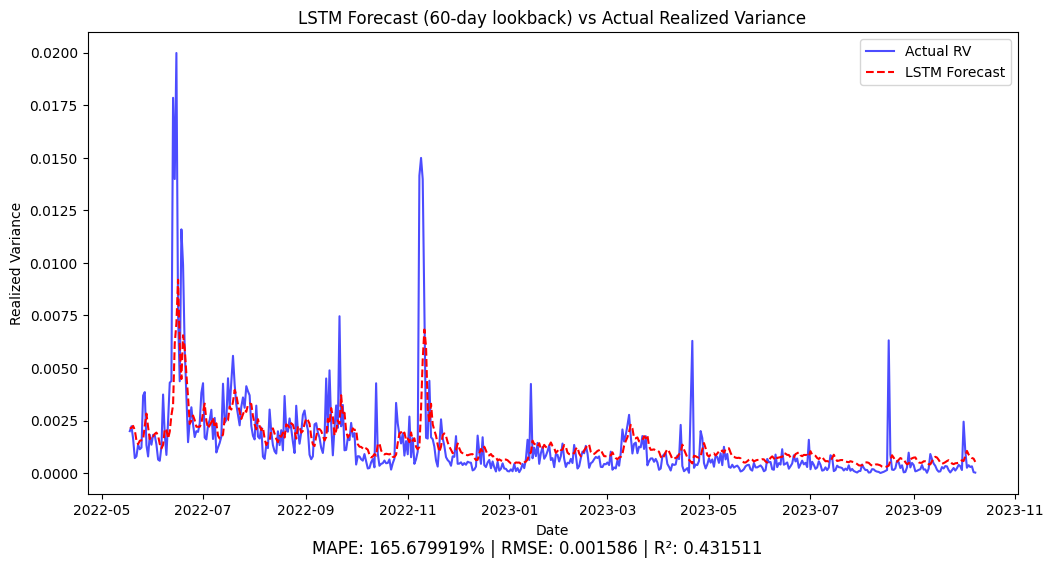

In [48]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt

# Load test set and inverse transform
test_actual = np.exp(scaler_y.inverse_transform(y_test.reshape(-1, 1)))[10:] 

# Load LSTM Forecasts
forecast_df = pd.read_csv("../../results/models/lstm_forecast.csv")
lstm_predictions = forecast_df["RV_forecast"].values[10:]


# 1️⃣ Calculate Error Metrics
mse = mean_squared_error(test_actual, lstm_predictions)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test_actual, lstm_predictions)
r2 = r2_score(test_actual, lstm_predictions)

# Print evaluation metrics
print(f"🔹 Mean Squared Error (MSE): {mse:.6f}")
print(f"🔹 Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"🔹 Mean Absolute Percentage Error (MAPE): {mape:.6%}")
print(f"🔹 R² Score: {r2:.6f}")

# 2️⃣ Plot Actual vs Predicted Realized Variance
plt.figure(figsize=(12,6))
plt.plot(data['time'].iloc[-len(test_actual):], test_actual, label="Actual RV", color="blue", alpha=0.7)  # ✅ Ensure time index matches test size
plt.plot(data['time'].iloc[-len(test_actual):], lstm_predictions, label="LSTM Forecast", color="red", linestyle="dashed")

plt.xlabel("Date")
plt.ylabel("Realized Variance")
plt.title(f"LSTM Forecast ({lookback}-day lookback) vs Actual Realized Variance")
plt.legend()

# 3️⃣ Add Captions
plt.figtext(0.5, 0.01, f"MAPE: {mape:.6%} | RMSE: {rmse:.6f} | R²: {r2:.6f}", wrap=True, horizontalalignment='center', fontsize=12)

# 4️⃣ Save Before Showing Plot
plt.savefig(f'../../results/figures/lstm_forecast_plot_{lookback}_lookback2.png')
plt.show()


In [46]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.regularizers import l2

def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(lookback, len(features))))
    
    # Select the number of LSTM layers (2, 3, or 4)
    num_layers = hp.Choice('num_layers', [3, 4])
    
    # Define first LSTM layer size
    first_layer_units = hp.Choice('lstm_units_0', [64, 128, 256]) 
    model.add(LSTM(
        units=first_layer_units,
        return_sequences=True,  
        activation=hp.Choice('activation', ['tanh', 'sigmoid']),
        kernel_regularizer=l2(0.001)  # Regularize only the first layer
    ))
    model.add(Dropout(hp.Choice('dropout_0', [0.1, 0.2])))

    # Add remaining layers with non-increasing units
    previous_units = first_layer_units  # Track previous layer units
    for i in range(1, num_layers):
        available_units = [u for u in [64, 128, 256] if u <= previous_units]  # Only allow non-increasing sizes
        current_units = hp.Choice(f'lstm_units_{i}', available_units)

        model.add(LSTM(
            units=current_units,
            return_sequences=True if i < num_layers - 1 else False,  
            activation=hp.Choice('activation', ['tanh', 'sigmoid'])
        ))
        model.add(Dropout(hp.Choice(f'dropout_{i}', [0.1, 0.2])))

        previous_units = current_units  # Update tracking variable

    model.add(Dense(1, activation=None))  # Output layer

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=[tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.RootMeanSquaredError()]
    )

    return model

# Define the tuner (Random Search with 10 trials)
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=30,  # Number of models to test
    executions_per_trial=1,  
    directory='tuning_results',
    project_name='lstm_hyperparameter_tuning',
    overwrite=False
)

# Perform Hyperparameter Tuning with Early Stopping
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=16, 
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
✅ Best Hyperparameters:
- Activation: {best_hps.get('activation')}
- LSTM Layers: {best_hps.get('num_layers')}
- LSTM Units per Layer: {[best_hps.get(f'lstm_units_{i}') for i in range(best_hps.get("num_layers"))]}
- Dropout Rates: {[best_hps.get(f'dropout_{i}') for i in range(best_hps.get("num_layers"))]}
""")

# Train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=16, verbose=1, 
                         callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

# Save the best model
best_model.save('../../results/models/lstm_best_model.keras')

print("✅ Hyperparameter tuning complete! Best model saved.")


Trial 30 Complete [00h 00m 38s]
val_loss: 0.2752954959869385

Best val_loss So Far: 0.2694520354270935
Total elapsed time: 00h 25m 33s

✅ Best Hyperparameters:
- Activation: tanh
- LSTM Layers: 3
- LSTM Units per Layer: [256, 64, 64]
- Dropout Rates: [0.2, 0.2, 0.1]

Epoch 1/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.7845 - mean_absolute_percentage_error: 496.7043 - root_mean_squared_error: 0.8755 - val_loss: 0.4247 - val_mean_absolute_percentage_error: 282.5283 - val_root_mean_squared_error: 0.6428
Epoch 2/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.5826 - mean_absolute_percentage_error: 284.0787 - root_mean_squared_error: 0.7555 - val_loss: 0.3515 - val_mean_absolute_percentage_error: 938.0090 - val_root_mean_squared_error: 0.5844
Epoch 3/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.5157 - mean_absolute_percentage_error: 321.9929 - root_mean_squared_error: 0.7113 - val_loss: 0.3489 - val_mean_absolute_percentage_error: 965.2604 - val_root_mean_squared